In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 46 kB/s 
     |████████████████████████████████| 199 kB 32.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=0422541cc6b638845ad43f75e914e4973e7bd9b50c0cf5ba7c581a3cab2fd709
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("analise_nlp") \
    .getOrCreate()

In [3]:
dados = spark.read.csv("/content/imdb-reviews-pt-br.csv", 
                       escape= '\"',
                       inferSchema=True,
                       header = True)

In [4]:

print(f'N° de linhas: {dados.count()}, N° de colunas {len(dados.columns)}')

N° de linhas: 49459, N° de colunas 4


In [ ]:
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [ ]:
dados.limit(99).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
| 11|Cage plays a drun...|Cage interpreta u...|      neg|
| 12|First of all, I w...|Primeiro de tudo,...|      neg|
| 13|So tell me - what...|Então me diga - q...|      neg|
| 14|A big disappointm...|Uma grande decepç...|      neg|
| 15|This film

In [5]:
print('Negativo')
dados.filter(dados.id == 190).select('text_pt').show(truncate= False)

print('Positivo')
dados.filter(dados.id == 12427).select('text_pt').show(truncate= False)

Negativo
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                 

In [6]:
dados.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

amostra = dados.select('text_pt').sample(fraction=0.1, seed = 101)
tudo =[texto['text_pt'] for texto in amostra.collect()]



In [8]:
wordcloud = WordCloud(
    background_color = 'white', 
    prefer_horizontal = 1, 
    collocations=False,
    width = 1000,
    height= 600,
    ).generate(str(tudo))

<function matplotlib.pyplot.show(*args, **kw)>

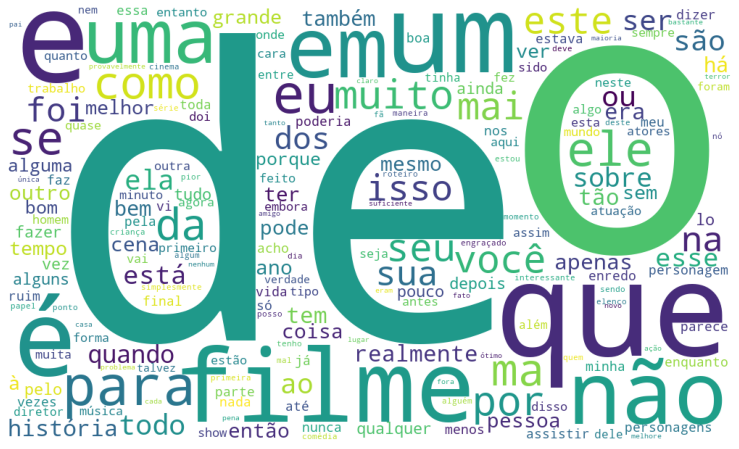

In [9]:
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show

In [26]:
import string 
string.punctuation
import pyspark.sql.functions as f

In [27]:
dados = dados.withColumn("texto_regex", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]", ""))

dados.limit(2).show(truncate = False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [28]:
dados = dados.withColumn("texto_limpo", f.trim(dados.texto_regex))

In [16]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_A = stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
from pyspark.ml.feature import StopWordsRemover

stop_B = StopWordsRemover.loadDefaultStopWords('portuguese')

In [29]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol="tokens")
tokenizado = tokenizer.transform(dados)

In [30]:
tokenizado.limit(11).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|              tokens|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|[once, again, mr,...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|[this, is, an, ex...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|[first, of, all, ...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Not even the Beat...|[not, even, the, ...|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|[brass, pictures,...|
|  6|A funny thing hap...|Uma co

In [42]:
remover = StopWordsRemover(inputCol = "tokens", outputCol="texto_final")
feature_data = remover.transform(tokenizado)

In [43]:
feature_data.limit(11).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|              tokens|         texto_final|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|[this, is, an, ex...|[example, majorit...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|[first, of, all, ...|[first, hate, mor...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Not even the Beat...|[not, even, the, ...|[even, beatles, w...|
|  5|B

In [36]:
tokenizado.select("texto_limpo", "tokens").show()

+--------------------+--------------------+
|         texto_limpo|              tokens|
+--------------------+--------------------+
|Once again Mr Cos...|[once, again, mr,...|
|This is an exampl...|[this, is, an, ex...|
|First of all I ha...|[first, of, all, ...|
|Not even the Beat...|[not, even, the, ...|
|Brass pictures mo...|[brass, pictures,...|
|A funny thing hap...|[a, funny, thing,...|
|This German horro...|[this, german, ho...|
|Being a longtime ...|[being, a, longti...|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|
|Wealthy horse ran...|[wealthy, horse, ...|
|Cage plays a drun...|[cage, plays, a, ...|
|First of all I wo...|[first, of, all, ...|
|So tell me  what ...|[so, tell, me, , ...|
|A big disappointm...|[a, big, disappoi...|
|This film is abso...|[this, film, is, ...|
|Heres a decidedly...|[heres, a, decide...|
|At the bottom end...|[at, the, bottom,...|
|Earth has been de...|[earth, has, been...|
|Many people are s...|[many, people, ar...|
|New York family i...|[new, york

In [44]:
from pyspark.sql.types import IntegerType
countTokens = f.udf(lambda tokens : len(tokens), IntegerType())
feature_data.select("tokens", "texto_final")\
  .withColumn("Freq_tokens", countTokens(f.col("tokens")))\
  .withColumn("Freq_tokens_limpos", countTokens(f.col("texto_final"))).show()

+--------------------+--------------------+-----------+------------------+
|              tokens|         texto_final|Freq_tokens|Freq_tokens_limpos|
+--------------------+--------------------+-----------+------------------+
|[once, again, mr,...|[mr, costner, dra...|        168|                73|
|[this, is, an, ex...|[example, majorit...|        232|               131|
|[first, of, all, ...|[first, hate, mor...|        215|               111|
|[not, even, the, ...|[even, beatles, w...|        308|               169|
|[brass, pictures,...|[brass, pictures,...|        238|               140|
|[a, funny, thing,...|[funny, thing, ha...|        115|                52|
|[this, german, ho...|[german, horror, ...|        156|                74|
|[being, a, longti...|[longtime, fan, j...|        136|                73|
|[tokyo, eyes, tel...|[tokyo, eyes, tel...|        129|                75|
|[wealthy, horse, ...|[wealthy, horse, ...|        160|                99|
|[cage, plays, a, ...|[ca

In [45]:
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="texto_final", outputCol="CountVec")
model = cv.fit(feature_data)
countVectorizer_features = model.transform(feature_data)

countVectorizer_features.select("texto_final", "CountVec").limit(5).show()

+--------------------+--------------------+
|         texto_final|            CountVec|
+--------------------+--------------------+
|[mr, costner, dra...|(221187,[0,7,8,11...|
|[example, majorit...|(221187,[1,2,3,8,...|
|[first, hate, mor...|(221187,[0,2,4,11...|
|[even, beatles, w...|(221187,[0,1,2,4,...|
|[brass, pictures,...|(221187,[1,3,5,8,...|
+--------------------+--------------------+



In [ ]:
model.vocabulary

In [48]:
from pyspark.ml.feature import HashingTF

hashingTF = HashingTF(inputCol="texto_final", outputCol="hashingTF")
hashingTF.setNumFeatures(50)

HTFfeaturizedData = hashingTF.transform(countVectorizer_features)


In [49]:
HTFfeaturizedData.select("texto_final", "hashingTF").limit(5).show()

+--------------------+--------------------+
|         texto_final|           hashingTF|
+--------------------+--------------------+
|[mr, costner, dra...|(50,[0,5,6,7,8,10...|
|[example, majorit...|(50,[0,1,2,3,4,5,...|
|[first, hate, mor...|(50,[0,1,2,3,5,6,...|
|[even, beatles, w...|(50,[0,1,2,3,4,5,...|
|[brass, pictures,...|(50,[0,1,2,3,4,5,...|
+--------------------+--------------------+



In [50]:
from pyspark.ml.feature import IDF
idf = IDF(inputCol="hashingTF", outputCol="features")
idfModel = idf.fit(HTFfeaturizedData)
TFIDFfeaturizedData = idfModel.transform(HTFfeaturizedData)

In [52]:
TFIDFfeaturizedData.select("texto_final", "features").limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

O **TF-IDF **significa Term Frequency - Inverse Document Frequency ou Frequência do Termo - Inverso da Frequência no Documento que não só contabiliza as palavras, mas também pondera baseado na fórmula abaixo. Em resumo, é levado em consideração a frequência do token não só naquela linha, mas também em todo conjunto de dados textuais analisado (corpus):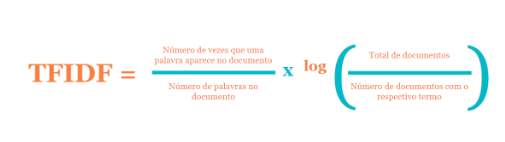

In [53]:
TFIDFfeaturizedData.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [54]:
from pyspark.ml.feature import StringIndexer

stringindexer = StringIndexer(inputCol="sentiment", outputCol="label")
dados = stringindexer.fit(dados).transform(dados)

In [55]:
dados.groupBy(['sentiment', 'label']).count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      pos|  1.0|24694|
|      neg|  0.0|24765|
+---------+-----+-----+



In [56]:
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")

pipeline = Pipeline(stages=[tokenizer, stopwords, hashingTF, tfidf])

In [60]:
dados_transformados = pipeline.fit(dados).transform(dados)

In [61]:
dados_transformados.limit(5).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|  0.0|[once, again, mr,...|[mr, costner, dra...|(1000,[10,21,34,4...|(1000,[10,21,34,4...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|  0.0|[this, is, an, ex...|[example, majorit...|(1000,[0,3,11,12,...|(1000,[0,3,11,12,...|
|  3|First of all I ha...|Primeiro de tudo ...|   

In [62]:
featureDF = dados_transformados.select(['features', 'label'])


In [63]:
featureDF.limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [64]:
featureDF.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [65]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")
dt = DecisionTreeClassifier(featuresCol= "features", labelCol="label", maxDepth=10)

pipeline = Pipeline(stages=[tokenizer, stopwords, hashingTF, tfidf, dt])

In [66]:
train, test = dados.randomSplit([0.7, 0.3], seed=101)

In [67]:
dt_model = pipeline.fit(train)

In [68]:
predictions = dt_model.transform(test)

In [69]:
predictions.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|  rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|  0.0|[brass, pictures,...|[brass, pictures,...|(1000,[3,6,7,11,3...|(1000,[3,6,7,11,3...| [369.0,1108.0]|[0.24983073798239...|       1.0|
|  6|A funny thing hap...|Uma coisa engraça...| 

In [71]:
predictions.select(['label', 'prediction']).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [72]:
# acuracia
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol ="prediction", metricName = "accuracy" )

acuracia = evaluator.evaluate(predictions)

In [73]:
print("Acuracia = %s" %(acuracia))

Acuracia = 0.6724021592442645
